In [148]:
#Import the essential libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller,kpss
import warnings

warnings.filterwarnings('ignore')

In [106]:
df = pd.read_csv('catfish.csv',index_col = [0],parse_dates = True)

In [107]:
df.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


<Axes: xlabel='Date'>

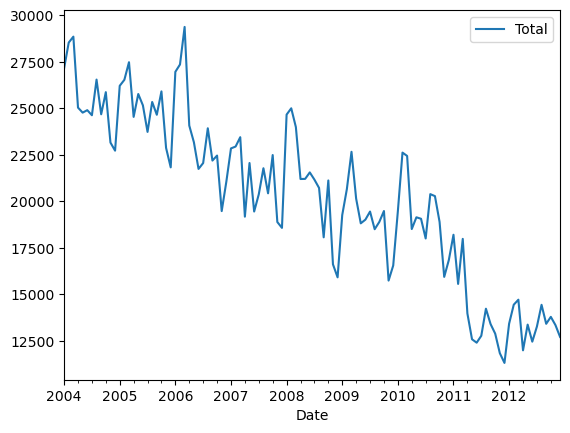

In [108]:
df = df.asfreq(pd.infer_freq(df.index))
df = df.loc[datetime(2004,1,1):]
df.plot()

In [109]:
def plot_time_series(series, title='Catfish Sales', ylabel='Value', xlabel='Date', figsize=(12, 6), color='blue'):
    """
    Plots a time series with date index.

    Parameters:
        series (pd.Series): Pandas Series with datetime index.
        title (str): Title of the plot.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        figsize (tuple): Size of the figure.
        color (str): Line color.
    """
    plt.figure(figsize=figsize)
    plt.plot(series, color=color, linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

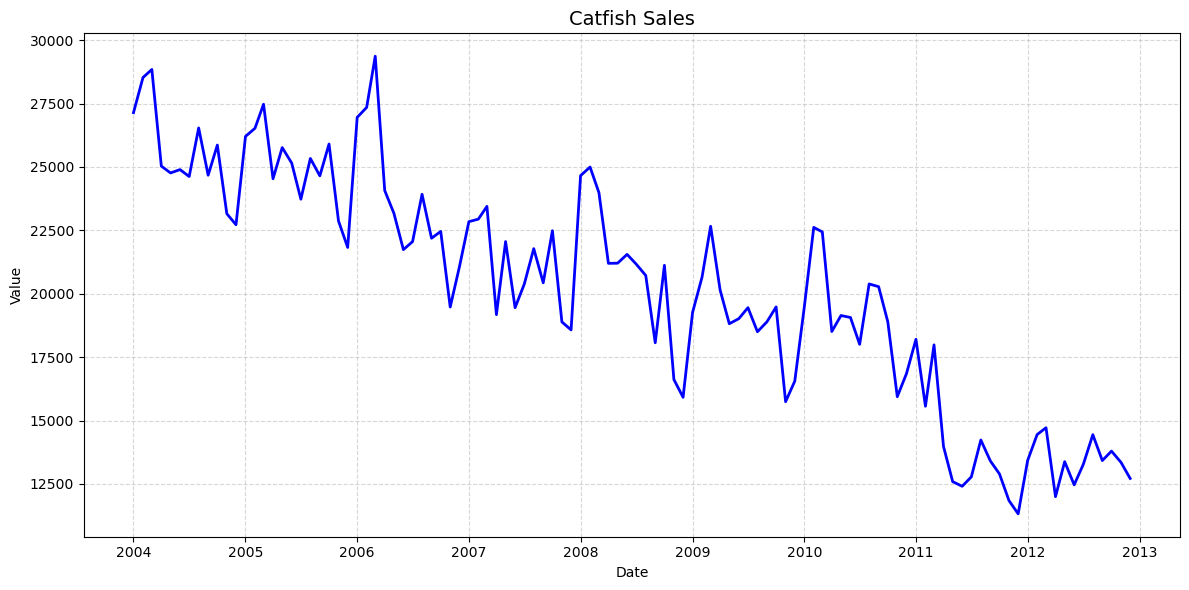

In [110]:
plot_time_series(df)

In [111]:
def check_stationarity(series, alpha=0.05, verbose=True):
    """
    Performs ADF & KPSS test to check stationarity of a time series.
    
    Parameters:
        series (pd.Series): The time series data.
        alpha (float): Significance level (default 0.05).
        verbose (bool): Whether to print detailed output.
    
    Prints:
        Results of the ADF test & KPSS test
    """
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lags': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        'Stationary': result[1] < alpha
    }

    if verbose:
        print("=== ADF Test Results ===")
        print(f"ADF Statistic     : {output['ADF Statistic']:.4f}")
        print(f"p-value           : {output['p-value']:.4f}")
        print(f"Used Lags         : {output['Used Lags']}")
        print(f"Observations Used : {output['Number of Observations']}")
        print("Critical Values   :")
        for key, value in output['Critical Values'].items():
            print(f"   {key} : {value:.4f}")
    result = kpss(series.dropna())
    output = {
        'KPSS Statistic': result[0],
        'p-value': result[1],
        'Used Lags': result[2],
        'Critical Values': result[3],
        'Stationary': result[1] < alpha
    }

    if verbose:
        print("=== KPSS Test Results ===")
        print(f"KPSS Statistic     : {output['KPSS Statistic']:.4f}")
        print(f"p-value           : {output['p-value']:.4f}")
        print(f"Used Lags         : {output['Used Lags']}")
        print("Critical Values   :")
        for key, value in output['Critical Values'].items():
            print(f"   {key} : {value:.4f}")


In [112]:
check_stationarity(df)

=== ADF Test Results ===
ADF Statistic     : -0.3833
p-value           : 0.9128
Used Lags         : 12
Observations Used : 95
Critical Values   :
   1% : -3.5011
   5% : -2.8925
   10% : -2.5833
=== KPSS Test Results ===
KPSS Statistic     : 1.7405
p-value           : 0.0100
Used Lags         : 5
Critical Values   :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


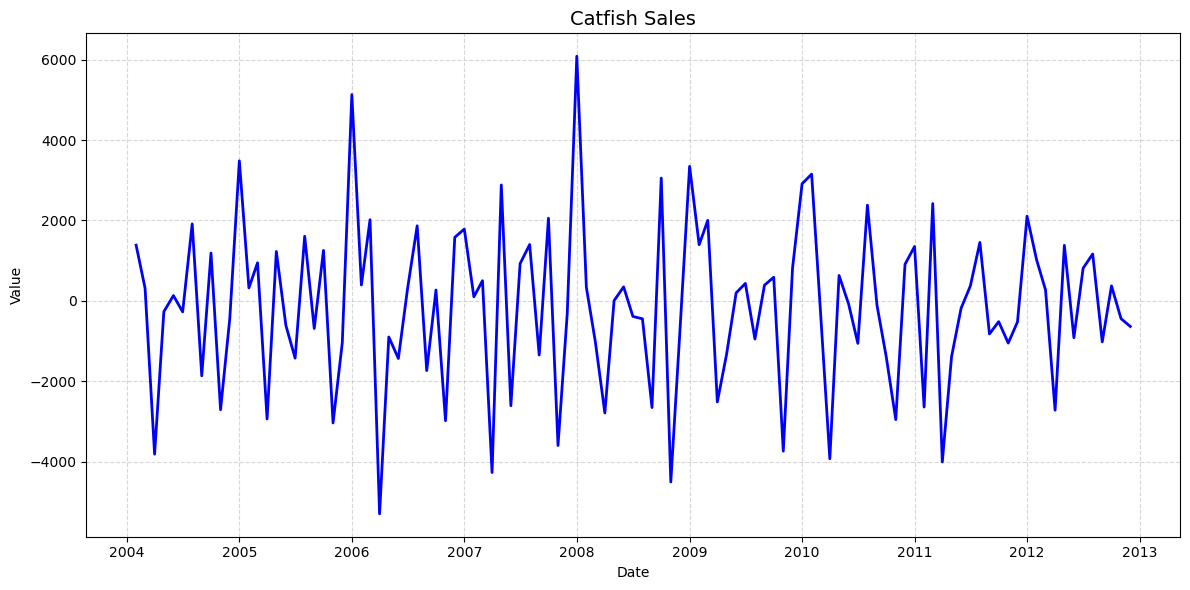

=== ADF Test Results ===
ADF Statistic     : -2.1668
p-value           : 0.2185
Used Lags         : 13
Observations Used : 93
Critical Values   :
   1% : -3.5027
   5% : -2.8932
   10% : -2.5836
=== KPSS Test Results ===
KPSS Statistic     : 0.0563
p-value           : 0.1000
Used Lags         : 10
Critical Values   :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


In [113]:
#The series is not stationary. So we will leverage first or second differencing to convert it to stationary
df = df.diff().dropna()
plot_time_series(df)
check_stationarity(df)

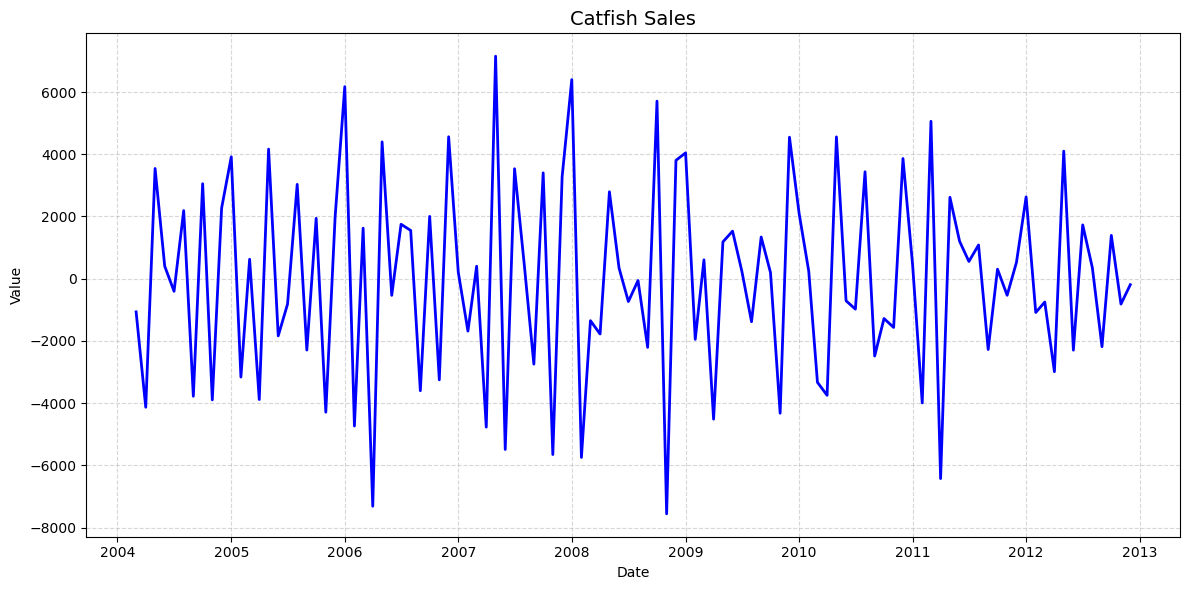

=== ADF Test Results ===
ADF Statistic     : -7.1623
p-value           : 0.0000
Used Lags         : 12
Observations Used : 93
Critical Values   :
   1% : -3.5027
   5% : -2.8932
   10% : -2.5836
=== KPSS Test Results ===
KPSS Statistic     : 0.1320
p-value           : 0.1000
Used Lags         : 25
Critical Values   :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


In [114]:
df = df.diff().dropna()
plot_time_series(df)
check_stationarity(df)

In [115]:
df

,Total
Date,
2004-03-01,-1067.0
2004-04-01,-4131.0
2004-05-01,3543.0
2004-06-01,401.0
2004-07-01,-405.0
...,...
2012-08-01,353.0
2012-09-01,-2186.0
2012-10-01,1393.0


In [116]:
def plot_acf_pacf(series, lags=10, alpha=0.05, title_prefix=''):
    """
    Plots the ACF and PACF of a time series.

    Parameters:
        series (pd.Series): The time series data.
        lags (int): Number of lags to show.
        alpha (float): Confidence interval level.
        title_prefix (str): Prefix to add to the plot titles.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    plot_acf(series, lags=lags, ax=axes[0], alpha=alpha)
    axes[0].set_title(f'{title_prefix} ACF')

    plot_pacf(series, lags=lags, ax=axes[1], alpha=alpha, method='ywm')
    axes[1].set_title(f'{title_prefix} PACF')

    plt.tight_layout()
    plt.show()

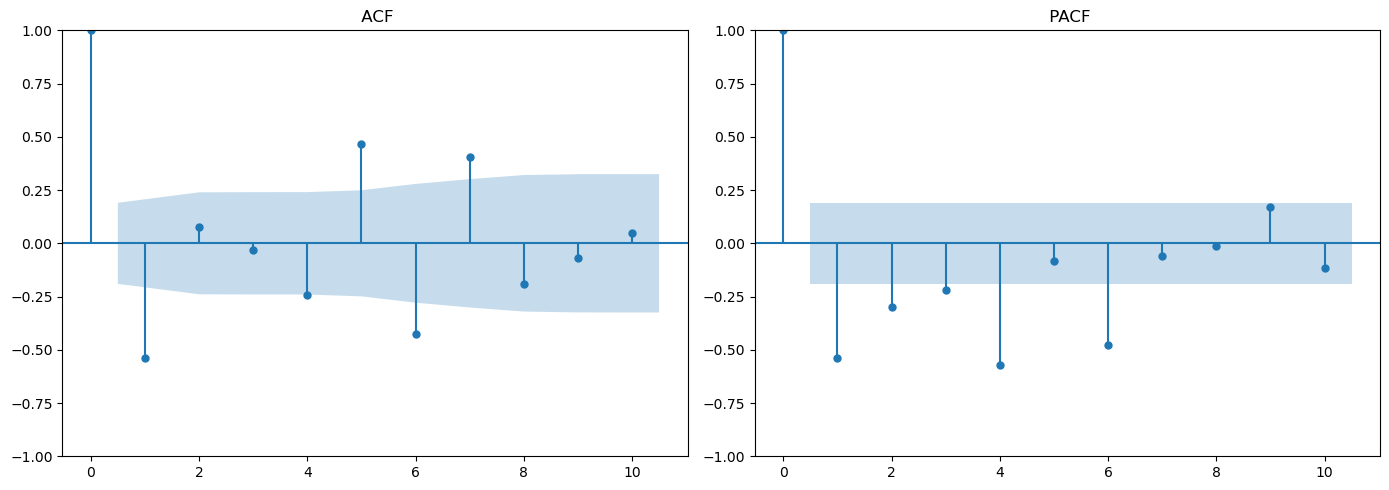

In [117]:
plot_acf_pacf(df)

,AR,AIC,BIC
0,AR (1),1980.860622,1988.850939
1,AR (2),1924.155957,1937.473153
2,AR (4),1893.102467,1914.409980
3,AR (6),1887.188786,1916.486616
4,AR (10),1874.689960,1917.304986


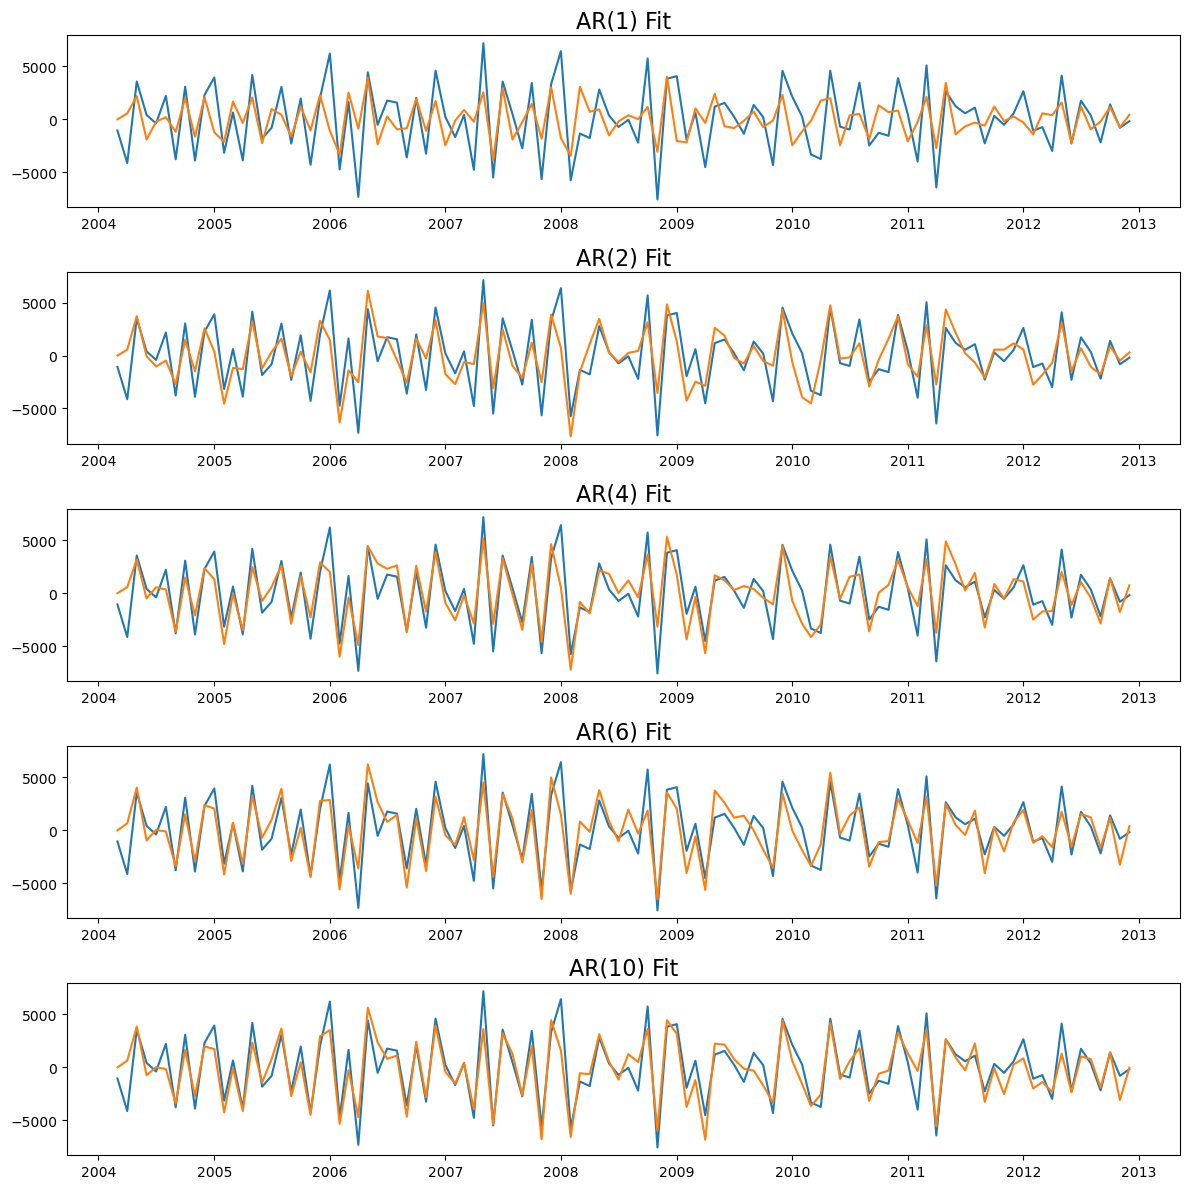

In [205]:
plt.figure(figsize=(12,12))
lags = [1,2,4,6,10]
fitted_model_dict = {}
aic_bic_df = pd.DataFrame(columns=['AR','AIC', 'BIC'])
for idx, lag in enumerate(lags):
    model = ARIMA(df,order=(lag, 0, idx))
    model = model.fit()
    bic = model.bic
    aic = model.aic
    aic_bic_df.loc[idx] = [f'AR ({lag})',aic,bic]
    #print(f"{idx} | {aic:.2f} | {bic:.2f}")
    plt.subplot(5,1,idx+1)
    plt.plot(df)
    plt.plot(model.fittedvalues)
    plt.title('AR(%s) Fit'%lag, fontsize=16)
plt.tight_layout()
aic_bic_df